In [112]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')

from lib import *

In [121]:
df_t = load_iedb_tcellepitopes(human_only=True)

In [102]:
S = 20
k = 9

Ntot = S**k
Nn = k*(S-1)

In [96]:
counter9 = count_kmers_proteome(human, k, clean=True)

In [95]:
human9 = set(counter9)
Nhuman = len(human9)

In [219]:
df = Counter(human, 1).to_df(norm=True, clean=True)
paa = np.asarray(df['freq'])
paa
pi = paa

psigmas = []
nsigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)

p0 = 1/N
pp = N*np.mean(psigmas**2)
print(pp, p0)
n0 = Nn/N
n = N*np.mean(psigmas*nsigmas)
print(n0, n)

9.434007609469387e-12 1.953125e-12
3.33984375e-10 1.3416108148668602e-09


In [224]:
tripletparams = calc_tripletmodelparams(human)

In [225]:
ptri = lambda seq: 10**loglikelihood_triplet(map_numbertoaa(seq), **tripletparams)


In [236]:
psigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    psigmas.append(psigma)
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
psigmas = np.asarray(psigmas)

pptri = N*np.mean(psigmas**2)
pptri

1.7097412056519943e-11

In [239]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

In [249]:
psigmas = []
nsigmas = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    nsigma = np.sum(np.fromiter((ptri(sigmap) for sigmap in neighbors(sigma, S)), np.float))
    psigmas.append(psigma)
    nsigmas.append(nsigma)
psigmas = np.asarray(psigmas)
nsigmas = np.asarray(nsigmas)

pptri = N*np.mean(psigmas**2)
ntri = N*np.mean(psigmas*nsigmas)
print(pptri, ntri/Nn)

1.8660773149397585e-11 1.3394655208517418e-11


In [250]:
# no human epitopes
mask = ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=False)
# no epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].isna()
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
# only infectious disease epitopes
#mask &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of infectious disease'
d = df_t[mask]

In [160]:
d['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             15122
Occurrence of infectious disease                                                    5965
Exposure with existing immune reactivity without evidence for disease               3684
Environmental exposure to endemic/ubiquitous agent without evidence for disease     2664
No immunization                                                                      994
Documented exposure without evidence for disease                                     244
Exposure without evidence for disease                                                147
Occurrence of autoimmune disease                                                      94
Occurrence of cancer                                                                  89
Occurrence of allergy                                                                 55
Occurrence of disease                                                                 24
Unknown              

In [123]:
d0 = d[d['Epitope', 'Description'].apply(lambda x: x in human9)]
#d0.head()

In [124]:
d0['Epitope', 'Parent Species'].unique()

array(['Mycobacterium tuberculosis', 'Chlamydia trachomatis',
       'Cavia porcellus', 'Human endogenous retrovirus K',
       'Leishmania major', 'Human betaherpesvirus 5'], dtype=object)

In [125]:
d0.shape[0], Nhuman*d.shape[0]*p0, Nhuman*d.shape[0]*pp

(20, 0.12118453223632814, 0.5836514365473207)

In [126]:
def dist1(x):
    for i in range(len(x)):
        for aa in aminoacids:
            if aa == x[i]:
                continue
            if x[:i]+aa+x[i+1:] in human9:
                return True
    return False

In [127]:
d1 = d[d['Epitope', 'Description'].apply(dist1)]
d1['Epitope', 'Parent Species'].unique()

array(['Hepatitis B virus', 'Mycobacterium tuberculosis', 'Hepacivirus C',
       'Borreliella burgdorferi', 'Plasmodium falciparum',
       'Plasmodium vivax', 'Chlamydia trachomatis',
       'Human gammaherpesvirus 4', 'Human metapneumovirus',
       'Trypanosoma cruzi', 'Human alphaherpesvirus 3',
       'Mycobacterium kansasii', 'Human alphaherpesvirus 1',
       'Alphapapillomavirus 9', 'Toxoplasma gondii',
       'Mycobacterium leprae', 'Human endogenous retrovirus K',
       'Dengue virus', 'Leishmania major',
       'Human immunodeficiency virus 1', 'Human betaherpesvirus 5'],
      dtype=object)

In [128]:
Ncomp = d.shape[0]*len(human9)
Ncomp*n0, Ncomp*n

(20.722555012412112, 82.9801147764068)

In [221]:
# no human epitopes
#mask = ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=False)
# no epitopes of unknown provenance
mask = ~df_t['Epitope', 'Parent Species'].isna()
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9

mask_noh = mask[:]
mask_noh &= ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=False)
mask1 = mask_noh[:]
mask1 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask2 = mask_noh[:]
mask2 &= df_t['Assay', 'Qualitative Measure'] == 'Negative'

mask &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask3 = mask[:]
mask3 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of infectious disease'
mask4 = mask[:]
mask4 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of allergy'
mask5 = mask[:]
mask5 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease'

1.953125e-12 1.5024306502489725e-11 7.84567727992316e-12
positive
2.1276913165079495e-10
1.338827986293891e-11
negative
4.747003249449207e-10
1.1545741555677896e-11
infectious
1.4783293331297674e-09
1.8371051654390385e-11
allergy
2.9580801367721598e-08
9.514292837571274e-11
autoimmune
8.438745279069467e-08
9.786587413730722e-11


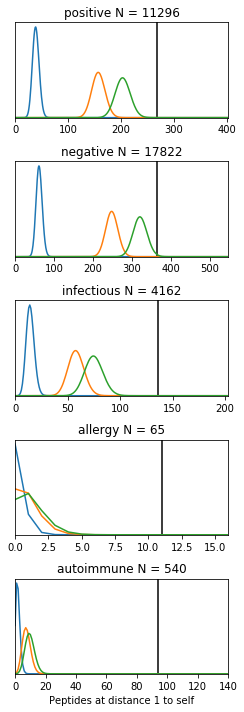

In [248]:
cases = [('positive', mask1),
         ('negative', mask2),
         ('infectious', mask3),
         ('allergy', mask4),
         ('autoimmune', mask5),
        ]
fig, axes = plt.subplots(figsize=(3.42, 2.0*len(cases)), nrows=len(cases), sharex=False)
print(1/N, pp, n/Nn)
for i, (name, mask) in enumerate(cases):
    print(name)
    ax = axes[i]
    d = df_t[mask]
    count0 = d[d['Epitope', 'Description'].apply(lambda x: x in human9)].shape[0]
    print(count0/(d.shape[0]*Nhuman))
    count1 = d[d['Epitope', 'Description'].apply(dist1)].shape[0] 
    print(count1/(d.shape[0]*Nhuman*Nn))
    ax.axvline(count1, c='k')
    ax.set_title(name + ' N = %g' % d.shape[0])
    x = np.arange(0, count1*1.5)
    Ncomp = d.shape[0]*Nhuman
    mu = Ncomp*n0
    ax.plot(x, poisson.pmf(x, mu), '-', ms=8, label='flat')
    mu = Ncomp*n
    ax.plot(x, poisson.pmf(x, mu), '-', ms=8, label='independent')
    mu = Ncomp*ntri
    ax.plot(x, poisson.pmf(x, mu), '-', ms=8, label='tri')
    #ax.legend()
    ax.set_ylim(0.0)
    ax.set_xlim(min(x), max(x))
    ax.set_yticks([])
ax.set_xlabel('Peptides at distance 1 to self')
fig.tight_layout()

# Analysis of flu epitopes

In [14]:
fluepis = df_t[df_t['Epitope', 'Parent Species'] == 'Influenza A virus']#['Epitope', 'Description'].unique()
fluepis.shape

(3024, 141)

In [15]:
fluepis['Epitope', 'Description'].unique().shape

(1266,)

(array([ 13., 114.,  58.,  27.,  14.,  65.,  31.,  86.,  53., 314., 234.,
        196.]),
 array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 <a list of 12 Patch objects>)

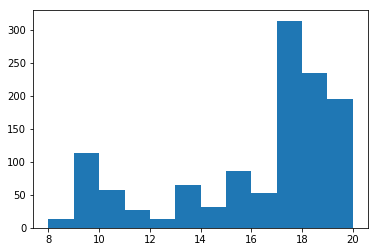

In [16]:
plt.hist([len(s) for s in fluepis['Epitope', 'Description'].unique()], bins=np.arange(8, 21))

In [18]:
nchunks = 100
btdist = BallTreeDist(human9, nchunks=nchunks)

In [19]:
fludists = [btdist.mindist(e) for e in fluepis[fluepis['Epitope', 'Description'].apply(len)==9]]

KeyError: 'Reference'

In [ ]:
proteomes = load_proteomes()


In [ ]:
df_flua = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['InfluenzaA']['path'], 9), norm=True)
df_flua.head()

In [ ]:
distss = []
for i in range(3):
    peptides = np.random.choice(df_flua['seq'], size=len(fludists), replace=False, p=df_flua['freq'])
    dists = [btdist.mindist(e) for e in peptides]
    distss.append(dists)

In [ ]:
counts = np.bincount(fludists)
print(counts)
plt.plot(counts, 'o')
for d in [distss[0], distss[1], distss[2]]:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
def dist2(x):
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            for aai in aminoacids:
                si = x[:i]+aai+x[i+1:]
                for aaj in aminoacids:
                    if (aai == x[i]) and (aaj == x[j]):
                        continue
                    if si[:j]+aaj+si[j+1:] in human9:
                        return True
    return False

In [ ]:
def dists_direct(df, ref):
    d0 = df[df['seq'].apply(lambda x: x in ref)].shape[0]/df['seq'].shape[0]
    d1 = df[df['seq'].apply(dist1)].shape[0]/df['seq'].shape[0]
    d2 = df[df['seq'].apply(dist2)].shape[0]/df['seq'].shape[0]
    return d0, d1, d2

In [ ]:
distsallflu = dists_direct(df_flua, human9)

In [ ]:
counts = np.bincount(fludists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallflu, 'x')

N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = lambda d: 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc(dists)*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)

In [ ]:
hivepis = d[d['Epitope', 'Parent Species'] == 'Human immunodeficiency virus 1']['Epitope', 'Description'].unique()
hivepis.shape

In [ ]:
hivdists = [mindist_sklearn_chunked(e, bts) for e in hivepis]

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'x')

In [ ]:
df_hiv1 = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['HIV']['path'], 9), norm=True)
df_hiv1.head()

In [ ]:
distss_hiv = []
for i in range(3):
    peptides = np.random.choice(df_hiv1['seq'], size=len(hivdists), replace=False, p=df_hiv1['freq'])
    dists = [mindist_sklearn_chunked(e, bts) for e in peptides]
    distss_hiv.append(dists)

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'o')
for d in distss_hiv:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
distsallhiv = dists_direct(df_hiv1, human9)

In [ ]:
counts = np.bincount(hivdists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallhiv, 'x')
N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = lambda d: 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc(dists)*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)